In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
#from sklearn.learning_curve import validation_curve
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, mean_squared_error, mean_squared_log_error
from sklearn.cluster import KMeans
import statsmodels.api as sm
import math
from scipy import stats
from scipy.stats import boxcox
from scipy.special import boxcox1p


In [2]:
from IPython.display import HTML
HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
*The raw code for this Jupyter notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')


In [3]:
# Load dataframe and add/clean columns

In [4]:
df = pd.read_csv('nfl_betting_df.csv', index_col = 0)

In [5]:
df['exp_win_difference'] = df.home_exp_win_pct- df.away_exp_win_pct
df['schedule_date']=df['schedule_date'].apply(pd.to_datetime)
df = df[df.schedule_season > 1978]

df['total_ppg'] = (df.h_ppg + df.a_ppg)
df['total_points_against'] = (df.h_papg + df.a_papg)
df['last_four_difference'] = (df.home_win_pct_last_4 - df.away_win_pct_last_4)

df[['weather_temperature', 'weather_wind_mph', 'weather_humidity']]=df[['weather_temperature', 'weather_wind_mph', 'weather_humidity']].fillna(value=np.round(df.mean(),3))
df[['over_under_line']]=df[['over_under_line']].fillna(value=(np.round(df.mean()*2)/2))

df['over_under_result'] = np.where(df['over_under_result']=='under', 0, df.over_under_result)
df['over_under_result'] = np.where(df['over_under_result']=='over', 1, df.over_under_result)
df['over_under_result'] = np.where(df['over_under_result']=='push', 2, df.over_under_result)

df['dome'] = np.where(df['weather_detail']=='DOME', 1, 0)

df = df.fillna(value = 0)

df.index = range(0, len(df))

In [6]:
reg_df = df[(df.schedule_week > 1) & (df.schedule_week < 19) & (df.schedule_season>2001)]
week5_df = df[(df.schedule_week > 4) & (df.schedule_week < 17) & (df.schedule_season>2001)]

In [7]:
# Regression Formulas

In [8]:
def poly_regression(x, y, degree_range, xlim_min, xlim_max, ylim_min, ylim_max, alpha = .75,s = 5,width = 2.5):
    plt.figure(figsize = (10,10))
    plt.ylim(ylim_min, ylim_max)
    plt.xlim(xlim_min,xlim_max)
    
    #split inputs into training and test sets
    split = train_test_split(x,y)
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    x = X_train
    y = y_train
    plt.scatter(x, y, s = s, alpha = alpha)
    
#     #conditional to plot points in diff color depending on game outcome
#     if str(y) == str(reg_df.over_under_line):
#         y1 = y[week5_df['over_under_result']==1]
#         y2 = y[week5_df['over_under_result']==0]
#         y3 = y[week5_df['over_under_result']==2]
#         x1 = x[week5_df['over_under_result']==1]
#         x2 = x[week5_df['over_under_result']==0]
#         x3 = x[week5_df['over_under_result']==2]
#         plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green', label = 'Over')
#         plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label = 'Under')
#         plt.scatter(x3, y3, s = s, alpha = .4, color = 'yellow', label = 'Push')
#     else:
#         y1 = y[week5_df['favorite_covered']==1]
#         y2 = y[week5_df['favorite_covered']==0]
#         y3 = y[week5_df['favorite_covered']==2]
#         x1 = x[week5_df['favorite_covered']==1]
#         x2 = x[week5_df['favorite_covered']==0]
#         x3 = x[week5_df['favorite_covered']==2]
#         plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green',label = 'Covered')
#         plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label ='No Cover')
#         plt.scatter(x3, y3, s = s, alpha = .4, color = 'yellow', label = 'Push')
        
    for degree in degree_range:
        poly_model = make_pipeline(PolynomialFeatures(degree),
                               LinearRegression())
        poly_model.fit(x[:, np.newaxis], y)
        xfit = np.linspace(xlim_min,xlim_max, 10000)
        yfit = poly_model.predict(xfit[:, np.newaxis])
        plt.plot(xfit, yfit, label = 'degree={}'.format(degree),linewidth=width)
    plt.legend(loc = 'best')


In [9]:
def log_linear_regression(x, y, degree_range, xlim_min, xlim_max, ylim_min, ylim_max, alpha = .75,s = 5,width = 2.5):
    #create figure and set size and axis lims
    plt.figure(figsize = (10,10))
    plt.ylim(ylim_min, ylim_max)
    plt.xlim(xlim_min,xlim_max)
    
    #split inputs into training and test sets
    split = train_test_split(x, np.log(np.abs(y)+1))
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    x = X_train
    y = y_train
    plt.scatter(x, y, s = s, alpha = alpha)

    #conditional to plot points in diff color depending on game outcome
    if str(y) == str(reg_df.over_under_line):
        y1 = y[reg_df['over_under_result']==1]
        y2 = y[reg_df['over_under_result']==0]
        x1 = x[reg_df['over_under_result']==1]
        x2 = x[reg_df['over_under_result']==0]
        plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green', label = 'Over')
        plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label = 'Under')
    else:
        y1 = y[reg_df['favorite_covered']==1]
        y2 = y[reg_df['favorite_covered']==0]
        x1 = x[reg_df['favorite_covered']==1]
        x2 = x[reg_df['favorite_covered']==0]
        plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green',label = 'Covered')
        plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label ='No Cover')
    
    for degree in degree_range:
        poly_model = make_pipeline(PolynomialFeatures(degree),
                               LinearRegression())
        poly_model.fit(x[:, np.newaxis], y)
        xfit = np.linspace(xlim_min,xlim_max, 10000)
        yfit = poly_model.predict(xfit[:, np.newaxis])
        plt.plot(xfit, yfit, label = 'degree={}'.format(degree),linewidth=width)
    plt.legend(loc = 'best')

In [10]:
def log_log_regression(x, y, degree_range, xlim_min, xlim_max, ylim_min, ylim_max, alpha = .75,s = 5,width = 2.5):
    #create figure and set size and axis lims
    plt.figure(figsize = (10,10))
    plt.ylim(ylim_min, ylim_max)
    plt.xlim(xlim_min,xlim_max)
    
    #split inputs into training and test sets
    split = train_test_split(np.log(x+1), np.log(np.abs(y)+1))
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    x = X_train
    y = y_train
    plt.scatter(x, y, s = s, alpha = alpha)

    #conditional to plot points in diff color depending on game outcome
    if str(y) == str(reg_df.over_under_line):
        y1 = y[reg_df['over_under_result']==1]
        y2 = y[reg_df['over_under_result']==0]
        x1 = x[reg_df['over_under_result']==1]
        x2 = x[reg_df['over_under_result']==0]
        plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green', label = 'Over')
        plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label = 'Under')
    else:
        y1 = y[reg_df['favorite_covered']==1]
        y2 = y[reg_df['favorite_covered']==0]
        x1 = x[reg_df['favorite_covered']==1]
        x2 = x[reg_df['favorite_covered']==0]
        plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green',label = 'Covered')
        plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label ='No Cover')
    
    for degree in degree_range:
        poly_model = make_pipeline(PolynomialFeatures(degree),
                               LinearRegression())
        poly_model.fit(x[:, np.newaxis], y)
        xfit = np.linspace(xlim_min,xlim_max, 10000)
        yfit = poly_model.predict(xfit[:, np.newaxis])
        plt.plot(xfit, yfit, label = 'degree={}'.format(degree),linewidth=width)
    plt.legend(loc = 'best')

In [11]:
# Regression Evaluations

In [12]:
def rmse_check(predictions, targets):

    differences = predictions - targets                       #the DIFFERENCEs.

    differences_squared = differences ** 2                    #the SQUAREs of ^

    mean_of_differences_squared = differences_squared.mean()  #the MEAN of ^

    rmse_val = np.sqrt(mean_of_differences_squared)           #ROOT of ^

    return rmse_val                                           #get the ^

In [13]:
def regression_evaluation(target, X_list):
    split = train_test_split(X_list, target,random_state=69)
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    X = X_train
    target = y_train
     
    X2 = sm.add_constant(X)
    est = sm.OLS(target, X2)
    est2 = est.fit()
    
    y_predicted = est2.fittedvalues
    y_actual = target
    rmse = math.sqrt(mean_squared_error(y_actual, y_predicted))
    residuals = y_actual-y_predicted
    
    plt.scatter(y_predicted,residuals)
    check = round(rmse_check(y_predicted, y_actual) - rmse)
    print(est2.summary())
    plt.scatter(y_predicted,residuals)
    plt.show()
    sns.distplot(residuals)
    print('RMSE=' + str(rmse) + ', check =' + str(check))

In [14]:
def log_log_regression_evaluation(target, X_list):
    split = train_test_split((np.log(np.abs(X_list)+1)), np.log(np.abs(target)+1))
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    X = X_train
    target = y_train
    
    X2 = sm.add_constant(X)
    est = sm.OLS(target, X2)
    est2 = est.fit()
    
    y_predicted = est2.fittedvalues
    y_actual = target
    
    log_rmse = math.sqrt(mean_squared_log_error(y_actual, y_predicted))
    residuals = y_actual-y_predicted

    #plt.scatter(y_predicted,residuals)
    print(est2.summary())
    sns.distplot(residuals)
    print('Log RMSE=' + str(log_rmse))

In [15]:
def log_linear_regression_evaluation(target,X_list):
    split = train_test_split(X_list, np.log(np.abs(target)+1))## log-linear eval
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    X = X_train
    target = y_train
    
    X2 = sm.add_constant(X)
    est = sm.OLS(target, X2)
    est2 = est.fit()
    
    y_predicted = est2.fittedvalues
    y_actual = target
    
    log_rmse = math.sqrt(mean_squared_log_error(y_actual, y_predicted))
    residuals = y_actual-y_predicted

    #plt.scatter(y_predicted,residuals)
    print(est2.summary())
    sns.distplot(residuals)
    print('Log RMSE=' + str(log_rmse))

## BoxCox Transformation for Over Under Line

In [16]:
yt,max_lambda =boxcox(week5_df.over_under_line)
# yt,max_lambda

# Variable 1 -Total Points Against

In [17]:
xt,max_lambda=boxcox(week5_df.total_points_against)
# xt,max_lambda


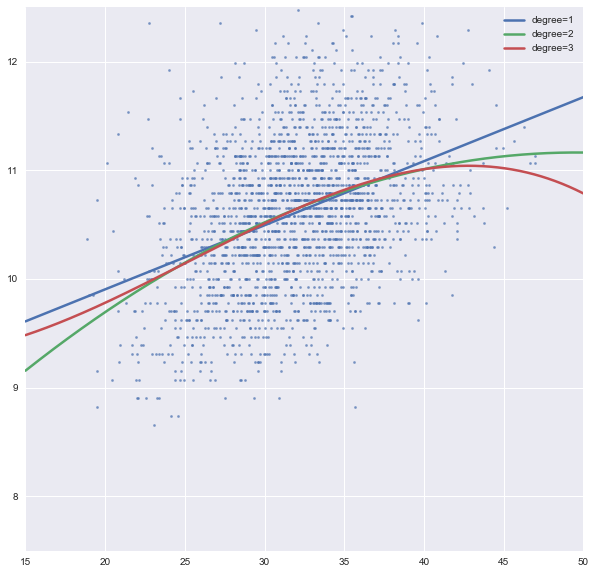

In [18]:
poly_regression(xt, yt,[1,2,3], 15,50, 7.5,12.5)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     388.7
Date:                Mon, 13 Aug 2018   Prob (F-statistic):           1.21e-79
Time:                        18:19:01   Log-Likelihood:                -2001.1
No. Observations:                2140   AIC:                             4006.
Df Residuals:                    2138   BIC:                             4017.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.7312      0.096     90.656      0.0

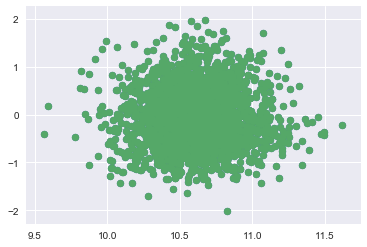

RMSE=0.6164031975541499, check =0.0


/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


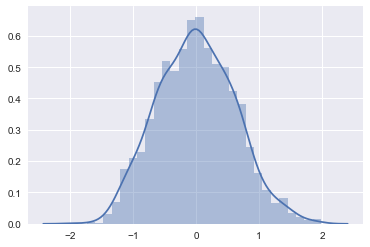

In [19]:
regression_evaluation(yt,xt)

# Variable 2 - Total PPG

In [20]:
yt,y_lambda =boxcox(week5_df.over_under_line)
xt,x_lambda = boxcox(week5_df.total_ppg)
# xt,x_lambda

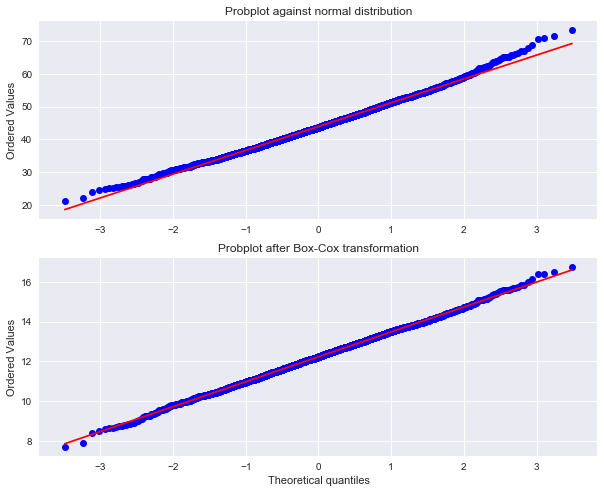

In [21]:
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(211)
x = week5_df.total_ppg
prob = stats.probplot(x, dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')

ax2 = fig.add_subplot(212)
xt, _ = stats.boxcox(x)
prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after Box-Cox transformation')
plt.show()

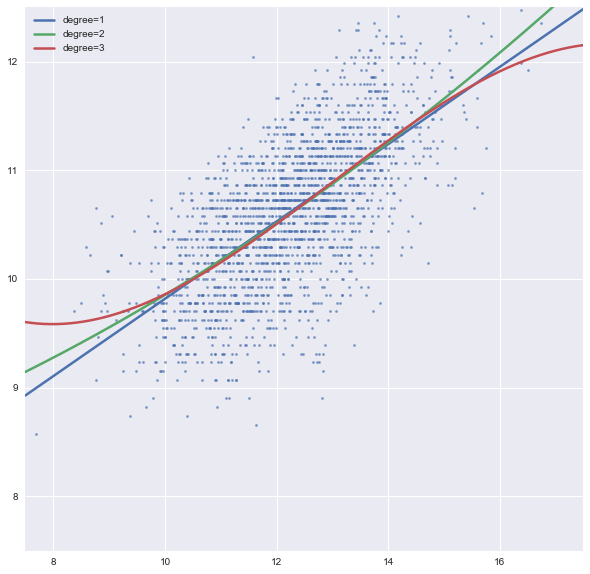

In [22]:
poly_regression(xt,yt,[1,2,3],7.5,17.5,7.5,12.5)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     1573.
Date:                Mon, 13 Aug 2018   Prob (F-statistic):          2.92e-258
Time:                        18:19:02   Log-Likelihood:                -1589.9
No. Observations:                2140   AIC:                             3184.
Df Residuals:                    2138   BIC:                             3195.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3230      0.109     58.165      0.0

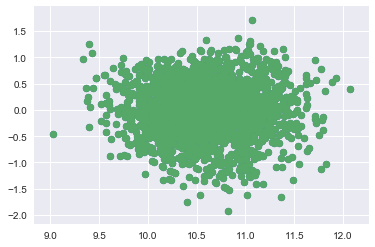

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


RMSE=0.5086546921676626, check =0.0


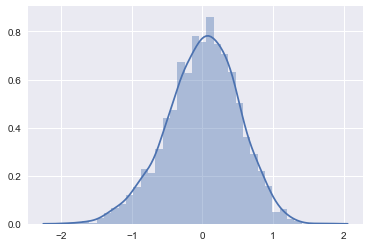

In [23]:
regression_evaluation(yt,xt)

# Variable 3 - Weather Temperature

In [24]:
yt,y_lambda =boxcox(week5_df.over_under_line)
xt,x_lambda = boxcox(week5_df.weather_temperature+1)
#xt,x_lambda


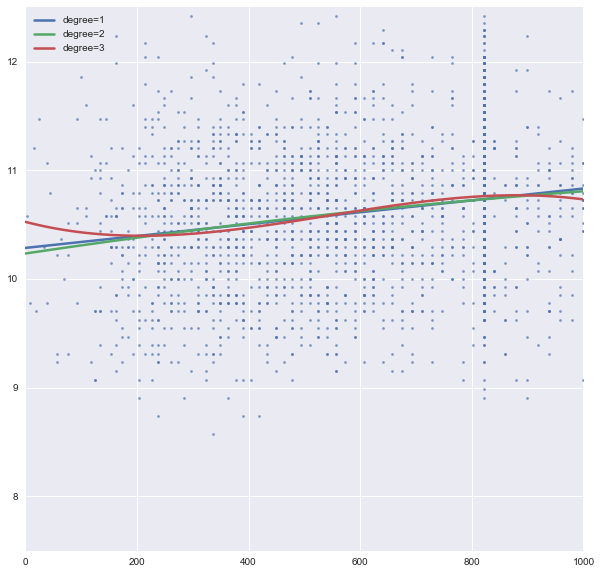

In [25]:
poly_regression(xt,yt,[1,2,3],0,1000,7.5,12.5)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     99.39
Date:                Mon, 13 Aug 2018   Prob (F-statistic):           6.50e-23
Time:                        18:19:03   Log-Likelihood:                -2131.2
No. Observations:                2140   AIC:                             4266.
Df Residuals:                    2138   BIC:                             4278.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.2593      0.038    269.344      0.0

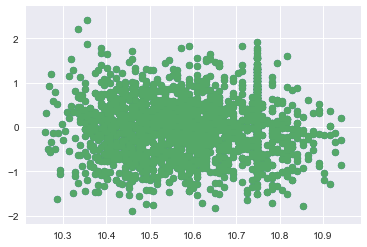

RMSE=0.6550496084341897, check =0.0


/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


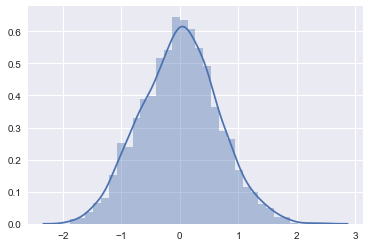

In [26]:
regression_evaluation(yt,xt)

# Variable 4 - Weather Wind mph

In [27]:
yt,y_lambda =boxcox(week5_df.over_under_line)
xt,x_lambda = boxcox(week5_df.weather_wind_mph+1)
#xt,x_lambda

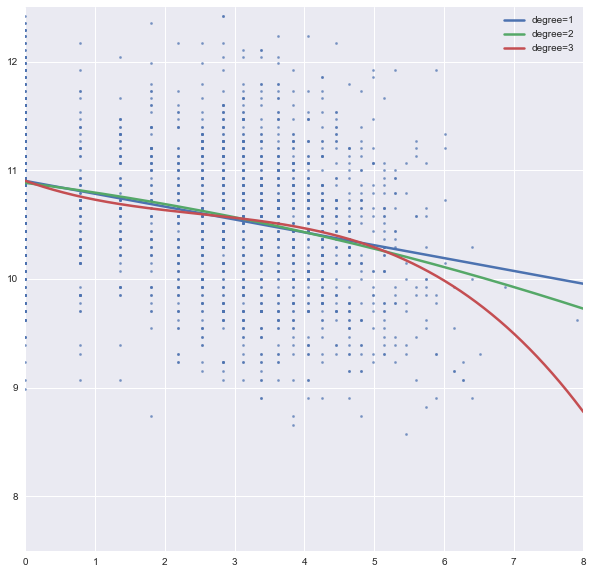

In [28]:
poly_regression(xt,yt,[1,2,3],0,8,7.5,12.5)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     252.7
Date:                Mon, 13 Aug 2018   Prob (F-statistic):           7.31e-54
Time:                        18:19:03   Log-Likelihood:                -2060.3
No. Observations:                2140   AIC:                             4125.
Df Residuals:                    2138   BIC:                             4136.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.9153      0.024    464.470      0.0

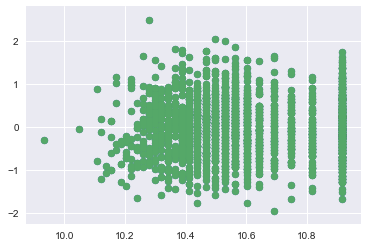

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


RMSE=0.6337025877592596, check =0.0


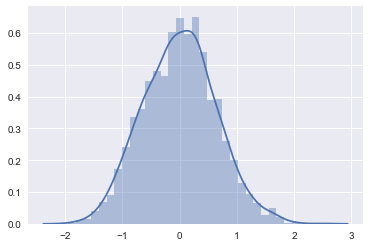

In [29]:
regression_evaluation(yt,xt)

# Variable 5 - Weather Humidity

In [30]:
yt,y_lambda =boxcox(week5_df.over_under_line)
xt,x_lambda = boxcox(week5_df.weather_humidity)
#xt,x_lambda

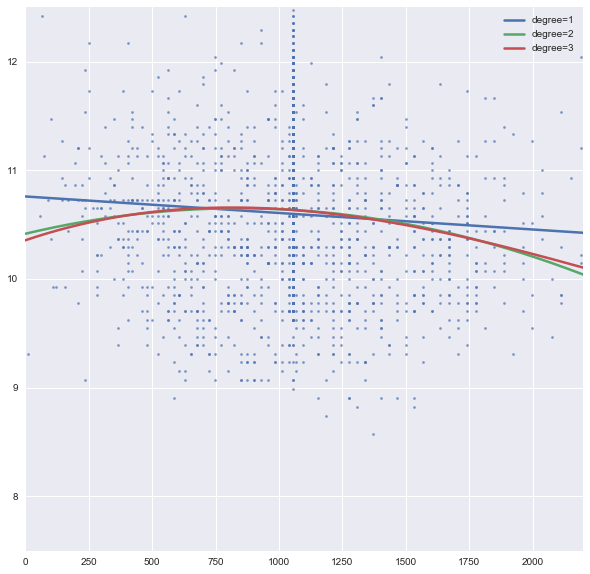

In [31]:
poly_regression(xt,yt,[1,2,3],0,2200,7.5,12.5)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     10.07
Date:                Mon, 13 Aug 2018   Prob (F-statistic):            0.00153
Time:                        18:19:04   Log-Likelihood:                -2174.8
No. Observations:                2140   AIC:                             4354.
Df Residuals:                    2138   BIC:                             4365.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.7570      0.048    224.115      0.0

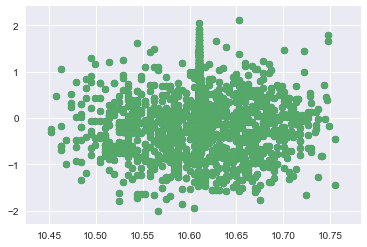

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


RMSE=0.6685306109083531, check =0.0


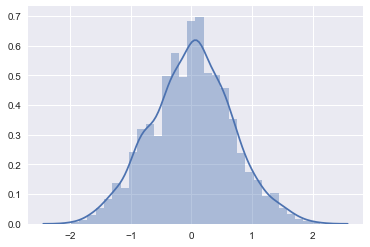

In [32]:
regression_evaluation(yt,xt)

# Variable 6 - Dome

In [33]:
yt,y_lambda =boxcox(week5_df.over_under_line)
xt,x_lambda = boxcox(week5_df.dome+1)
#xt,x_lambda

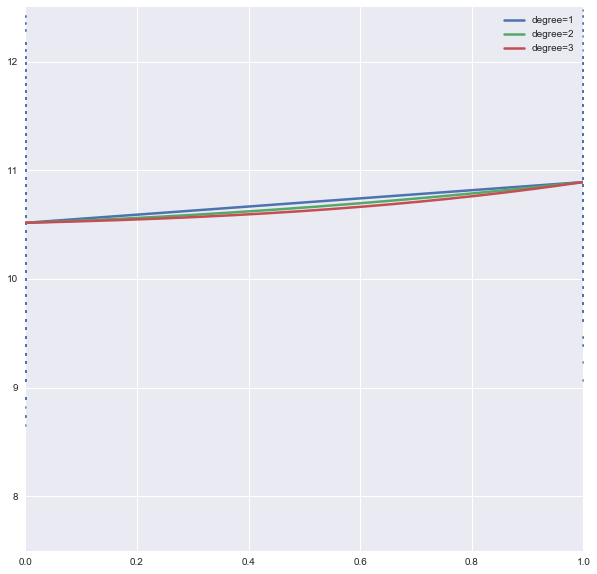

In [34]:
poly_regression(week5_df.dome,yt,[1,2,3],0,1,7.5,12.5)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     166.7
Date:                Mon, 13 Aug 2018   Prob (F-statistic):           8.67e-37
Time:                        18:19:05   Log-Likelihood:                -2099.5
No. Observations:                2140   AIC:                             4203.
Df Residuals:                    2138   BIC:                             4214.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.5114      0.016    657.834      0.0

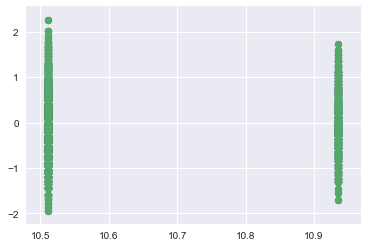

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


RMSE=0.6454064721781986, check =0.0


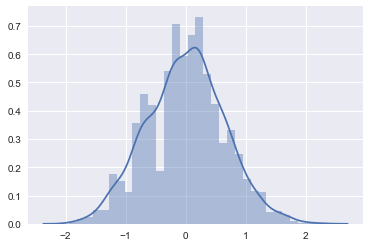

In [35]:
regression_evaluation(yt,week5_df.dome)

# variable 7 - season

In [36]:
xt7,xlam7=boxcox(week5_df.schedule_season)
# xt7,xlam7
# max(xt7)

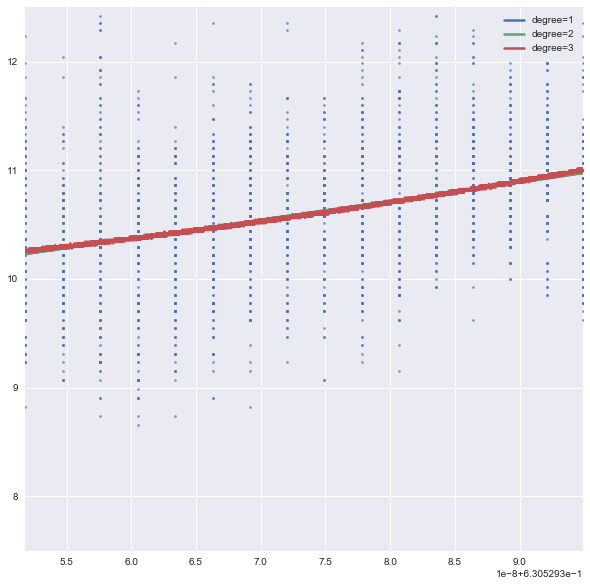

In [37]:
poly_regression(xt7,yt,[1,2,3],.6305293518286147,.6305293949256964,7.5,12.5)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     284.6
Date:                Mon, 13 Aug 2018   Prob (F-statistic):           4.75e-60
Time:                        18:19:06   Log-Likelihood:                -2046.1
No. Observations:                2140   AIC:                             4096.
Df Residuals:                    2138   BIC:                             4108.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.095e+07   6.49e+05    -16.871      0.0

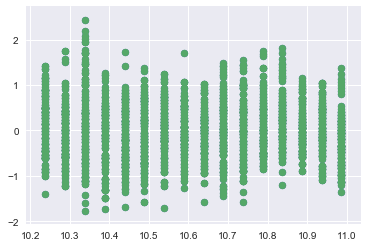

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


RMSE=0.6295090088624903, check =0.0


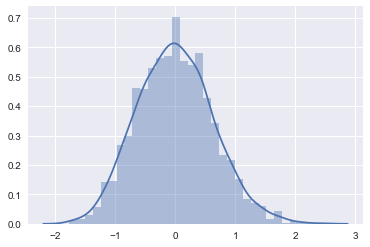

In [38]:
regression_evaluation(yt,xt7)

# Regression of Over Under with all variables

In [39]:
yt,y_lambda =boxcox(week5_df.over_under_line)
xt1,xlam1 = boxcox(week5_df.total_points_against)
xt2,xlam2 = boxcox(week5_df.total_ppg)
xt3,xlam3 = boxcox(week5_df.weather_temperature+1)
xt4,xlam4 = boxcox(week5_df.weather_wind_mph+1)
xt5,xlam5 = boxcox(week5_df.weather_humidity)
xt7,xlam7=boxcox(week5_df.schedule_season)
ou_regression_df = pd.DataFrame([xt1,xt2,xt3,xt4,xt5,week5_df.dome,xt7]).T
ou_regression_df.columns=['Total Points Against','Total PPG','Temp','Wind MPH','Humidity','Dome','Season']
#ou_regression_df.head()
#len(ou_regression_df)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     703.0
Date:                Mon, 13 Aug 2018   Prob (F-statistic):               0.00
Time:                        18:19:06   Log-Likelihood:                -899.74
No. Observations:                2140   AIC:                             1815.
Df Residuals:                    2132   BIC:                             1861.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -2.576e+06 

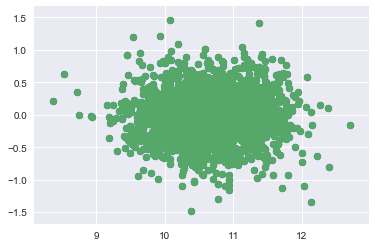

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


RMSE=0.36843151723373724, check =-0.0


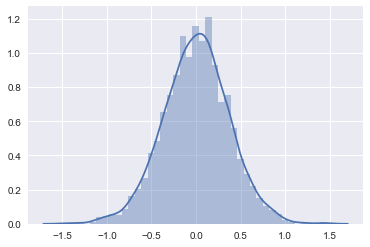

In [40]:
regression_evaluation(yt,ou_regression_df)